In [1]:
import pandas as pd
import numpy as np

CREATING FINAL DATASET FROM THE FILTERED COLUMNS DATASET

In [2]:
filtered_file_path='filtered_dataset.csv.gz'

In [3]:
chunk_size = 200000  # Adjust based on memory availability
filtered_chunks = []

for chunk in pd.read_csv(filtered_file_path, chunksize=chunk_size, on_bad_lines='skip', encoding='utf-8',compression="gzip", low_memory=False):
    filtered_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
filtered_df = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks

In [4]:
print(filtered_df.shape)

(3628367, 28)


In [6]:
beverage_keywords = [
    "Beverages and beverages preparations", "Beverages", "sodas", "drinks", "juices", "teas",
    "artificially sweetened beverages", "basil seeds drinks", "carbonated drinks", "coffee drinks", "dairy drinks",
    "dehydrated beverages", "energy drinks", "fermented drinks", "flavoured drinks", "herbal tea beverages",
    "hot beverages", "milsubstitutes", "mixed drinks", "non-alcoholic beverages", "still soft drinks",
    "plant-based beverages", "sweetened beverages", "tea-based beverages", "unsweetened beverages",
    "waters", "fr:Citronnades", "Boissons"
]

# Common global drink-related terms for substring matching in main_category
beverage_substrings = [
    "water", "drink","drinks" "juice", "soda", "teas", "coffee", "nectar", "carbonated", "milkshake", 
    "smoothie", "lemonade", "coconut-waters", "non-alcoholic", "infusion", "isotonic",
    "cold-brew", "plant-based-drinks", "kombucha", "protein-shake","tonic", 
    "ginger-beers", "electrolyte-drinks", "beverages", "ciders" 
]

# Convert to lowercase for case-insensitive matching
beverage_keywords_lower = {kw.lower() for kw in beverage_keywords}
beverage_substrings_lower = {kw.lower() for kw in beverage_substrings}

def check_categories(categories_str):
    """Check if any non-alcoholic beverage keyword exists in the 'categories' column."""
    if pd.isna(categories_str):
        return False
    category_list = [c.strip().lower() for c in categories_str.split(",")]
    return any(cat in beverage_keywords_lower for cat in category_list)

def check_main_category(main_category_str):
    """Check if 'main_category' contains any beverage-related substring."""
    if pd.isna(main_category_str):
        return False
    main_category = main_category_str.split(":", 1)[-1].strip().lower()
    parts = main_category.replace("-", " ").split()
    return any(any(sub in part for sub in beverage_substrings_lower) for part in parts)

# Apply conditions to each column
categories_condition = filtered_df['categories'].apply(check_categories)
main_category_condition = filtered_df['main_category'].apply(check_main_category)

# Combine conditions using logical OR
mask = categories_condition | main_category_condition

In [7]:
filtered_df2 = filtered_df[mask]
print(filtered_df2.shape)
print("---Before filter---")
print(filtered_df2['fruits-vegetables-nuts-estimate-from-ingredients_100g'].isnull().sum())
filtered_df2.loc[
    filtered_df2['fruits-vegetables-nuts-estimate-from-ingredients_100g'].isna() &  # If 3rd column is NaN
    (filtered_df2[['fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g']].notna().sum(axis=1) >= 1),  # At least one of the other two has a value
    'fruits-vegetables-nuts-estimate-from-ingredients_100g'
] = filtered_df2[['fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g']].mean(axis=1)

print("---After filter---")
# Check missing values after filling
print(filtered_df2['fruits-vegetables-nuts-estimate-from-ingredients_100g'].isnull().sum())

(173379, 28)
---Before filter---
79635
---After filter---
79312


In [7]:
# filtered_df2 = filtered_df2.drop(columns=['fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g'])
print(filtered_df2.shape) 
print(filtered_df2.isnull().sum().sort_values())

(173379, 28)
categories                                                    0
main_category                                                 0
nutriscore_grade                                              4
countries                                                   753
product_name                                               5707
energy_100g                                               54082
fat_100g                                                  56217
proteins_100g                                             56332
sugars_100g                                               57295
energy-kcal_100g                                          57636
sodium_100g                                               64242
salt_100g                                                 64242
saturated-fat_100g                                        70405
nutrition-score-fr_100g                                   74329
nutriscore_score                                          74329
fruits-vegetables-nuts-esti

In [8]:
filtered_df2['sugars_100g'].fillna(filtered_df2['added-sugars_100g'])
filtered_df2['sugars_100g'].isnull().sum()

57295

In [17]:
filtered_df3 = filtered_df2.drop(columns=['categories','countries','fat_100g','allergens','energy-kcal_100g','energy-kj_100g','trans-fat_100g','added-sugars_100g','sodium_100g','chloride_100g','fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g', 'nutrition-score-fr_100g',])
filtered_df3.sample(5)

,product_name,main_category,quantity,ingredients_tags,additives_tags,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutriscore_score,nutriscore_grade
83595,Diet ginger ale juice,en:sodas,NaN,"en:carbonated-water,en:water,en:e330,en:natura...","en:e150c,en:e212,en:e330,en:e950,en:e951",0.0,NaN,0.0,NaN,0.0,0.025,NaN,0.0,4.0,c
3506737,Mountain Dew 750 ml,en:sweetened-beverages,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
3286210,Zumo de Pina,en:pineapple-juices,NaN,NaN,NaN,218.0,0.0,9.9,NaN,0.6,0.000,NaN,NaN,6.0,c
2406309,Dictamos Cretan Tea,en:beverages,20pcs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
262536,Kola Champion Original,en:sweetened-beverages,330 ml,"en:carbonated-water,en:water,en:sugar,en:added...","en:e211,en:e330",243.0,0.01,14.4,0.0,0.5,0.010,NaN,0.0,15.0,e


In [14]:
# List of columns to check for non-null values
columns_to_check = [
    'energy_100g', 'saturated-fat_100g', 'sugars_100g', 
    'fiber_100g', 'proteins_100g', 'salt_100g', 
    'fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

# Count the number of non-null values in the specified columns
non_null_count = filtered_df3[columns_to_check].notnull().sum(axis=1)
print(non_null_count)
# Keep only rows where at least 4 of the columns have values
filtered_df3 = filtered_df3[non_null_count >= 4]

filtered_df3.loc[:, columns_to_check] = filtered_df3.loc[:, columns_to_check].fillna(0)

# Verify the changes
print(filtered_df3.shape)  # Should print 0 for all selected columns
# filtered_df4.sample(5)
filtered_df3.sample(5)

4          1
5          5
7          7
8          7
9          6
          ..
3627933    4
3628002    6
3628020    5
3628291    0
3628338    7
Length: 173379, dtype: int64
(116256, 15)


,product_name,main_category,quantity,ingredients_tags,additives_tags,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutriscore_score,nutriscore_grade
443934,Strawberry Kiwi Pouches,en:juices-and-nectars,10 x 6 oz,"en:filtered-water,en:water,en:sugar,en:added-s...",en:e330,118.0,0,6.21,0.0,0.0,0.0212,NaN,11.815,7.0,d
2432333,Caffè lungo,en:coffee-capsules,NaN,"en:ground-roasted-coffee,en:coffee,en:ground-c...",NaN,0.0,0.0,0.00,0.0,0.0,0.0000,NaN,0.000,0.0,b
2392800,Ultra Watermelon Zero Sugar,en:energy-drinks,500ml,NaN,NaN,13.0,0.0,0.00,0.0,0.5,0.1000,NaN,0.000,0.0,b
3002327,Sapore di malga,en:herbal-fruit-teas-in-tea-bags,NaN,NaN,NaN,4.0,0.0,0.10,0.0,0.0,0.0000,NaN,0.000,0.0,b
1704525,Mojito (offre éco),en:sweetened-beverages,NaN,"en:water,en:lemon-juice,en:fruit,en:juice,en:f...",en:e300,151,0,9.30,0.0,0.1,0.0000,NaN,17.000,11,e


In [11]:
# newdd = filtered_df3[(filtered_df3['nutriscore_grade'] == 'not-applicable')]

filtered_df3.nunique().sort_values()

nutriscore_grade                                             7
nutriscore_score                                           111
alcohol_100g                                               129
fiber_100g                                                1203
saturated-fat_100g                                        1903
proteins_100g                                             2339
main_category                                             3598
energy_100g                                               3637
salt_100g                                                 4320
sugars_100g                                               4553
quantity                                                  5503
fruits-vegetables-nuts-estimate-from-ingredients_100g     7477
additives_tags                                           11410
ingredients_tags                                         56287
product_name                                             80801
dtype: int64

In [12]:

count = filtered_df3['nutriscore_grade'].isin(['unknown', 'not-applicable']).sum()
print(f"Number of rows to be removed: {count}")

# Remove these rows
filtered_df3 = filtered_df3[~filtered_df3['nutriscore_grade'].isin(['unknown', 'not-applicable'])]

# Verify removal
print(f"Remaining rows: {len(filtered_df3)}")
print(filtered_df3['nutriscore_grade'].unique())


Number of rows to be removed: 22738
Remaining rows: 93518
['c' 'e' 'b' 'd' 'a']


In [13]:
filtered_df3.sample(5)

,product_name,main_category,quantity,ingredients_tags,additives_tags,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,alcohol_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutriscore_score,nutriscore_grade
3322075,Polvorón sabor naranja,en:christmas-foods-and-drinks,NaN,NaN,NaN,1565.0,14.0,14.40,0.0,6.9,0.5000,NaN,0.0,20.0,e
2767343,Ice tea peach,en:peach-flavored-iced-teas,0.5 l,"fr:infusion-de-the-noir-avec-cynorrhodon,en:ro...",en:e330,136.0,0.1,8.00,0.0,0.5,0.0100,NaN,6.0,8.0,d
2100066,Hella Birne,en:beverages,NaN,NaN,NaN,75.0,0.0,4.20,0.0,0.0,0.0000,NaN,0.0,4.0,c
211907,Caffeine free soda,en:sodas,NaN,"en:carbonated-water,en:water,en:high-fructose-...","en:e110,en:e129,en:e211,en:e330,en:e414,en:e445",226.0,0,14.08,0.0,0.0,0.0500,NaN,0.0,14.0,e
333201,Energy drink,en:sodas,NaN,"en:filtered-water,en:water,en:sugar,en:added-s...","en:e110,en:e202,en:e211,en:e330,en:e331,en:e34...",84.0,0,4.60,0.0,0.0,0.0375,NaN,0.0,8.0,d


In [14]:
filtered_df4 = filtered_df3.drop(columns=["alcohol_100g"])

categorical_cols = ['product_name', 'quantity', 'ingredients_tags']

# Replace missing values with a placeholder
filtered_df4[categorical_cols] = filtered_df4[categorical_cols].fillna("unknown")

filtered_df4.columns = filtered_df4.columns.str.replace('-', '_')
filtered_df4 = filtered_df4.rename(columns={
    'fruits_vegetables_nuts_estimate_from_ingredients_100g': 'fruits_veg_nuts_100g'
})
filtered_df4.columns
# Output:
# ['fat_100g', 'saturated_fat_100g', 'fruits_vegetables_nuts_estimate_from_ingredients_100g']


Index(['product_name', 'main_category', 'quantity', 'ingredients_tags',
       'additives_tags', 'energy_100g', 'saturated_fat_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits_veg_nuts_100g',
       'nutriscore_score', 'nutriscore_grade'],
      dtype='object')

In [15]:
import pandas as pd

# Create a condition where all the relevant columns are 0
condition = (filtered_df4[['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'fiber_100g', 
                           'proteins_100g', 'salt_100g', 'fruits_veg_nuts_100g']].eq(0)).all(axis=1)

# Filter out rows where all the relevant columns are 0, and nutriscore_grade is between 'b' and 'e'
new_filtered_df = filtered_df4[~(condition & filtered_df4['nutriscore_grade'].isin(['b', 'c', 'd', 'e']))]

# Convert columns to numeric, forcing errors to NaN (this will handle any invalid strings or power notation)
cols_to_check = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits_veg_nuts_100g']

new_filtered_df[cols_to_check] = new_filtered_df[cols_to_check].apply(pd.to_numeric, errors='coerce')

# Define the conditions where any one column exceeds the threshold
condition1 = (
    (new_filtered_df['energy_100g'] > 500) | (new_filtered_df['energy_100g'] < 0) |
    (new_filtered_df['saturated_fat_100g'] > 20) | (new_filtered_df['saturated_fat_100g'] < 0) |
    (new_filtered_df['sugars_100g'] > 25) | (new_filtered_df['sugars_100g'] < 0) |
    (new_filtered_df['proteins_100g'] > 10) | (new_filtered_df['proteins_100g'] < 0) |
    (new_filtered_df['salt_100g'] > 15) | (new_filtered_df['salt_100g'] < 0) |
    (new_filtered_df['fiber_100g'] > 10) | (new_filtered_df['fiber_100g'] < 0) |
    (new_filtered_df['fruits_veg_nuts_100g'] > 100) | (new_filtered_df['fruits_veg_nuts_100g'] < 0)
)

# Remove rows where any condition is matched
new_filtered_df1 = new_filtered_df[~condition1]

# Display the filtered dataframe
new_filtered_df1.shape


C:\Users\apran\AppData\Local\Temp\ipykernel_3040\590122092.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_filtered_df[cols_to_check] = new_filtered_df[cols_to_check].apply(pd.to_numeric, errors='coerce')


(79862, 14)

In [16]:
filtered_file = "final_dataset.csv"

num_features = [
    'energy_100g', 'saturated_fat_100g', 'sugars_100g',
    'fiber_100g', 'proteins_100g', 'salt_100g',
    'fruits_veg_nuts_100g',
]
label = ['nutriscore_grade']

# Split data
newfinalData = new_filtered_df1[num_features + label]
newfinalData.to_csv(filtered_file, index=False,encoding='utf-8')
newfinalData.shape

(79862, 8)

Optional Ferther processing Code. Not taken actully

In [17]:
# Convert the 'energy_100g' column to numeric, invalid values will be set to NaN
newfinalData['energy_100g'] = pd.to_numeric(newfinalData['energy_100g'].astype(str).str.strip(), errors='coerce')
newfinalData['energy_100g'].dtype

newfinalData['saturated_fat_100g'] = pd.to_numeric(newfinalData['saturated_fat_100g'].astype(str).str.strip(), errors='coerce')
newfinalData['saturated_fat_100g'].dtype

C:\Users\apran\AppData\Local\Temp\ipykernel_3040\1911623023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newfinalData['energy_100g'] = pd.to_numeric(newfinalData['energy_100g'].astype(str).str.strip(), errors='coerce')
C:\Users\apran\AppData\Local\Temp\ipykernel_3040\1911623023.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newfinalData['saturated_fat_100g'] = pd.to_numeric(newfinalData['saturated_fat_100g'].astype(str).str.strip(), errors='coerce')


dtype('float64')

In [18]:
newfinalData.describe()

,energy_100g,saturated_fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits_veg_nuts_100g
count,79862.000000,79862.000000,79862.000000,79862.000000,79862.000000,79862.000000,79862.000000
mean,139.447694,0.156098,6.147828,0.139919,0.587082,0.103493,15.549444
std,97.796822,0.571443,4.729197,0.459663,1.221422,0.662235,30.266505
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,154.000000,0.000000,6.110556,0.000000,0.028200,0.010000,0.000000
75%,203.000000,0.100000,10.000000,0.000000,0.500000,0.070000,13.750000
max,499.000000,20.000000,25.000000,10.000000,10.000000,15.000000,100.000000


In [19]:
# Define an upper threshold for multiple columns
upper_thresholds = newfinalData[['fiber_100g', 'salt_100g', 'saturated_fat_100g','energy_100g','sugars_100g','proteins_100g','fruits_veg_nuts_100g']].quantile(0.99)

# Apply filtering for each column separately
for col in upper_thresholds.index:
    newfinalData = newfinalData[newfinalData[col] <= upper_thresholds[col]]

# Check results
newfinalData.describe()


,energy_100g,saturated_fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits_veg_nuts_100g
count,75925.000000,75925.000000,75925.000000,75925.000000,75925.000000,75925.00000,75925.000000
mean,133.022887,0.110198,6.066964,0.105925,0.486394,0.04984,15.618963
std,91.346766,0.311891,4.589529,0.276580,0.941167,0.10725,30.330227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,53.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
50%,146.000000,0.000000,6.110000,0.000000,0.000000,0.01000,0.000000
75%,199.000000,0.080000,10.000000,0.000000,0.500000,0.05660,13.988929
max,394.000000,2.300000,16.000000,1.900000,6.060606,1.00000,100.000000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = newfinalData1[['salt_100g','energy_100g','sugars_100g','proteins_100g','fruits_veg_nuts_100g']]
# Function to cap extreme outliers
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

# Apply capping to all numeric columns
for col in numeric_columns:
    cap_outliers(newfinalData1, col)

NameError: name 'newfinalData1' is not defined

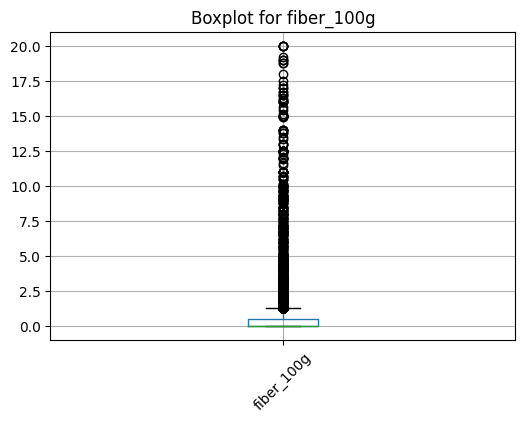

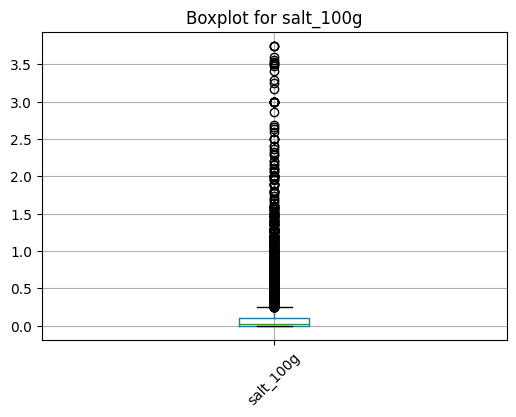

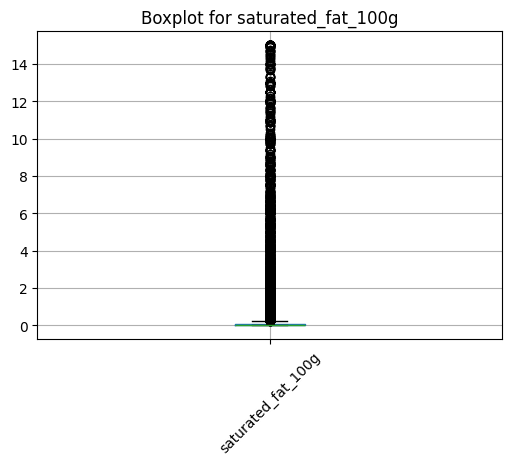

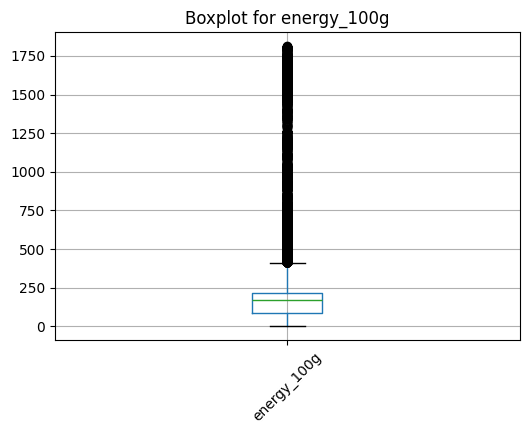

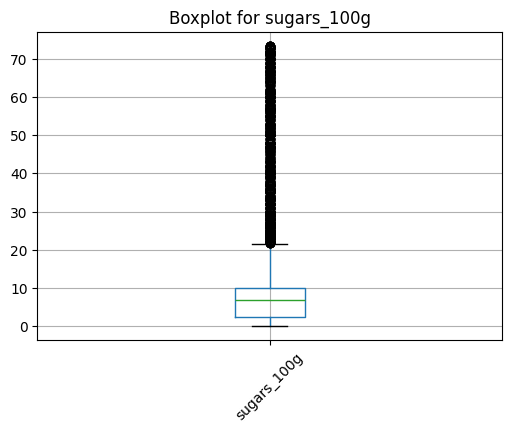

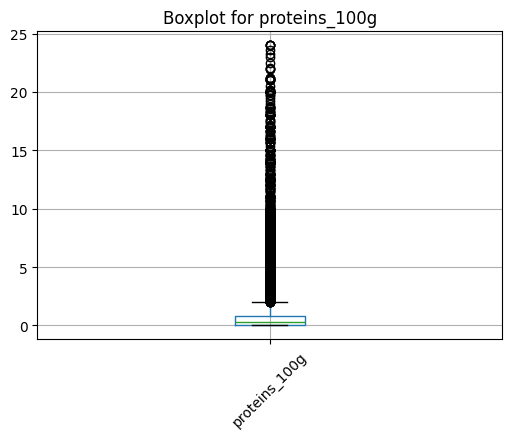

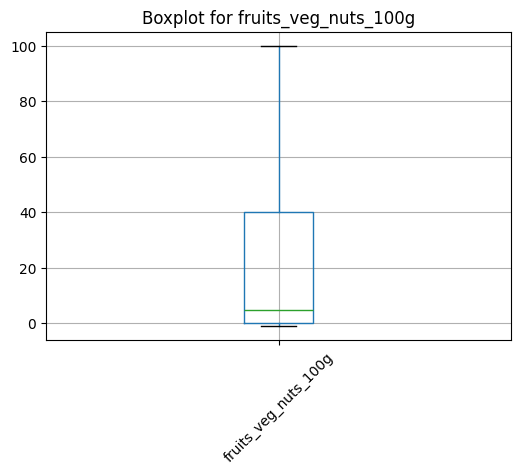

In [ ]:
numeric_columns = newfinalData1[['fiber_100g', 'salt_100g', 'saturated_fat_100g','energy_100g','sugars_100g','proteins_100g','fruits_veg_nuts_100g']]

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    newfinalData1.boxplot(column=col)
    plt.title(f"Boxplot for {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
newfinalData1.describe()

,energy_100g,saturated_fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits_veg_nuts_100g,sweetener_present
count,29031.000000,29031.000000,29031.000000,29031.000000,29031.000000,29031.000000,29031.000000,29031.000000
mean,191.847667,0.308779,7.220382,0.399787,0.954294,0.076134,25.960345,0.012711
std,226.499353,1.251767,7.772504,1.116328,2.056886,0.193098,36.488007,0.112024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.955621,0.000000
25%,86.000000,0.000000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172.000000,0.000000,6.779661,0.000000,0.300000,0.020000,4.585000,0.000000
75%,216.000000,0.100000,10.000000,0.500000,0.800000,0.100000,40.000000,0.000000
max,1812.000000,15.000000,73.500000,20.000000,24.000000,3.750000,100.000000,1.000000


In [ ]:
filtered_file = "final_dataset_clean.csv"
newfinalData1.to_csv(filtered_file, index=False,encoding='utf-8')
newfinalData1.shape

(29031, 9)

MAKING DATA FOR NLP PROCESSING

In [ ]:
import pandas as pd

# Load the dataset
file_path = "final_dataset.csv"
df = pd.read_csv(file_path)

# Define the columns to include in the text column
columns_to_include = [
    "energy_100g", "saturated_fat_100g", "sugars_100g", "fiber_100g",
    "proteins_100g", "salt_100g", "fruits_veg_nuts_100g", "sweetener_present"  
]

# Populate the 'text' column without extra decimal points
df["text"] = df[columns_to_include].apply(lambda row: ','.join(f"{col}:{int(row[col]) if row[col] % 1 == 0 else row[col]}" for col in columns_to_include), axis=1)

# Save the modified dataset
df = df.drop(columns=["energy_100g", "saturated_fat_100g", "sugars_100g", "fiber_100g", 
                      "proteins_100g", "salt_100g", "fruits_veg_nuts_100g", "sweetener_present"])
output_file = "final_dataset_updated.csv"
df.to_csv(output_file,index=False)